## Paso 1: Cargar el conjunto de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import randint
from mlflow import MlflowClient
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.sklearn


In [2]:
data = pd.read_csv("../data/train.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Paso 2: Limpiar los datos

### Paso 2.1: Manejo de datos faltantes

In [3]:
missing_values = data.isnull().sum()
print(missing_values)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


### Paso 2.2: Manejo de valores atípicos

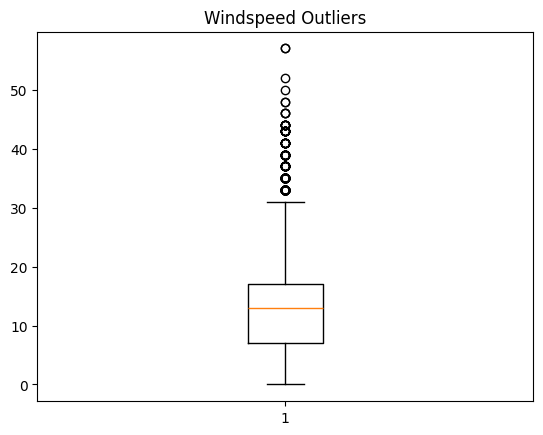

In [4]:
# Box Plot to detect outliers in windspeed
plt.boxplot(data['windspeed'])
plt.title('Windspeed Outliers')
plt.show()

In [5]:
# Cap windspeed at a maximum threshold if necessary
data["windspeed"] = data["windspeed"].clip(upper=40)

### Paso 2.3: Valores erróneos

In [6]:
data = data[data['temp'] >= 0]

## Paso 3: Ingeniería de características

### Paso 3.1: Características de fecha y hora

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [8]:
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.day_of_week
data['month'] = data['datetime'].dt.month

### Paso 3.2: Patrones climáticos

In [9]:
data['is_clear_weather'] = (data['weather'] == 1).astype(int)
data['is_rainy_weather'] = (data['weather'] >= 3).astype(int)

### Paso 3.3: Interacción entre días festivos y días laborables

In [10]:
data['is_holiday_workingday'] = ((data['holiday'] == 1) & (data['workingday'] == 1))

## Paso 4: Eliminar columnas irrelevantes

In [11]:
data.drop(columns=["datetime"], inplace=True)

## Paso 5: Seperar los datos

In [12]:
# Split the data into features and target
X = data.drop(columns=["count"])
y = data["count"]

In [13]:
# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Verify the split
print(f"Training data size: {X_train.shape}")
print(f"Testing data sizes: {X_test.shape}")

Training data size: (8708, 16)
Testing data sizes: (2178, 16)


## Paso 6: Entrenamiento de modelos con seguimiento de MLflow

2025/04/29 17:37:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training complete. MAE: 3.6803246669967646, RMSE: 7.088694908391736


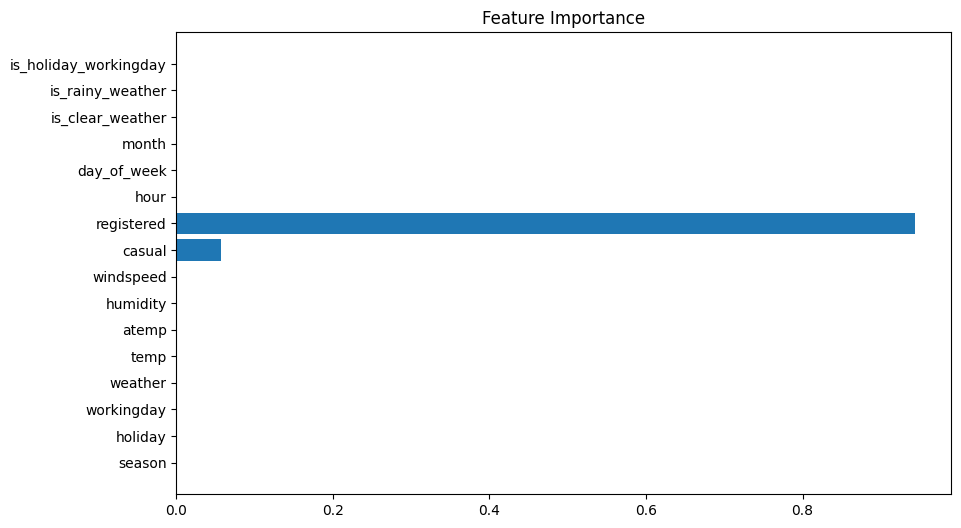

In [15]:

model = DecisionTreeRegressor(max_depth=10, random_state=42)

# Start an MLFlow run
with mlflow.start_run():
    # Log model parameters
    mlflow.log_params({
        "model_type": "DecisionTreeRegressor",
        "max_depth": 10
    })
    mlflow.log_params({
        "max_depth": 10
    })

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # Log evaluation metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)

    # Plot and log feature importance as an artifact
    feature_importances = model.feature_importances_

    plt.figure(figsize=(10, 6))
    plt.barh(X_train.columns, feature_importances)
    plt.title("Feature Importance")
    plt.savefig("feature_importance.png")

    # Log the artifact (the feature importance plot)
    mlflow.log_artifact("feature_importance.png")

    # Log the model itself
    mlflow.sklearn.log_model(model, "model")

print(f"Model training complete. MAE: {mae}, RMSE: {rmse}")

In [16]:
model = DecisionTreeRegressor(random_state=42)
param_gird = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 10, 20]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_gird, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Start an MLFlow run for hyperparameter tuning
with mlflow.start_run():
    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Log the best hyperparameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("best_min_samples_split", best_params['min_samples_split'])

    # Log the best score (cross-validated)
    best_score = -grid_search.best_score_
    mlflow.log_metric("best_cross_val_score", best_score)

    # Log the final model
    best_model = grid_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")

    # Evaluate the model on the test set and log the result
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)

print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025/04/29 17:37:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 10}
Test RMSE: 6.645717111734768


In [17]:
# Define the hyperparameter distributions
param_distributions = {
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 20)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
    )

# Perform RandomizedSearchCV with MLFLow tracking
with mlflow.start_run():
    random_search.fit(X_train, y_train)

    # Log the best hyperparameters and metrics
    best_params = random_search.best_params_
    mlflow.log_param("best_max_depth", best_params["max_depth"])
    mlflow.log_param("best_min_samples_split", best_params["min_samples_split"])

    best_score = -random_search.best_score_

    mlflow.log_metric("best_cross_val_score", best_score)

    # Log the best model
    best_model = random_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")

    # Evaluate and log test set performace
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)

print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025/04/29 17:37:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 5}
Test RMSE: 6.240402041286485


## Paso 7: Evaluación del modelo

In [18]:
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [19]:
# Log the metrics using MLFlow
with mlflow.start_run():
    mlflow.log_metric("R2", r2)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)

In [20]:
print(f"R2 {r2:.3f}")
print(f"RMSE {rmse:.3f}")
print(f"MAE: {mae:.3f}")

R2 0.999
RMSE 6.240
MAE: 2.891


## Paso 8: Despliegue de modelos con MLFlow

### Paso 8.1: Modelos de MLFlow: Guardar el modelo con mejor desempeño

In [21]:
with mlflow.start_run():
    # Take the first row of the training dataset as the model input example.
    input_example = X_train.iloc[[0]]

    mlflow.sklearn.log_model(best_model, "bike_prediction_model", input_example=input_example)
    print("Model saved successfully!")

c:\Users\guill\Documents\GitHub\mlops-bike-prediction-pipeline\mlops-env\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Model saved successfully!


### Paso 8.2: Guardar el modelo: Usar MLFlow para desplegar mediante una API REST

In [22]:
# !mlflow models serve -m "runs:/<run_id>/bike_prediction_model" -p 1234 --no-conda

In [23]:
!curl -X POST -H "Content-Type: application/json" -d '{"dataframe_split":{"columns":["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","casual","registered","hour","day_of_week", "month","is_clear_weather","is_rainy_weather","is_holiday_workingday"],"data":[[3.0,0.0,1.0,1.0,33.62,40.15,59.0,0.0,29.0,98.0,11.0,1.0,7.0,1.0,0.0,0.0]]}}' http://127.0.0.1:1234/invocations

curl: (3) unmatched close brace/bracket in URL position 62:
month,is_clear_weather,is_rainy_weather,is_holiday_workingday],data:[[3.0,0.0,1.0,1.0,33.62,40.15,59.0,0.0,29.0,98.0,11.0,1.0,7.0,1.0,0.0,0.0]]}}'
                                                             ^


## Paso 9: Supervisión del modelo desplegado

### Paso 9.1: Seguimiento del rendimiento en tiempo real

In [24]:
def monitor_real_time_predictions(model, X_live, y_true):
    y_pred = model.predict(X_live)

    # Calculate real-time metrics
    mae_live = mean_absolute_error(y_true, y_pred)
    rmse_live = mean_squared_error(y_true, y_pred, squared=False)

    # Log live data performance metrics using MLFLow
    with mlflow.start_run():
        mlflow.log_metric("MAE_live", mae_live)
        mlflow.log_metric("RMSE_live", rmse_live)

    print(f"Real-time MAE: {mae_live}")
    print(f"Real-time RMSE: {rmse_live}")

In [25]:
# monitor_real_time_predictions(desployed_model, X_live, y_true_live)

## Paso 10: Gestión del ciclo de vida del modelo

### Paso 10.1: Registrar el modelo en el registro de MLFlow

In [26]:
with mlflow.start_run() as run:
    # Take the first row of the trainig dataset as the model input example
    input_example = X_train.iloc[[0]]

    mlflow.sklearn.log_model(best_model, "bike_prediction_model", input_example=input_example)


    # Register the model in the model registry
    model_uri = f"runs/{run.info.run_id}/bike_prediction_model"
    mlflow.register_model(model_uri, "BikePredictionModel")

c:\Users\guill\Documents\GitHub\mlops-bike-prediction-pipeline\mlops-env\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'BikePredictionModel'.
Created version '1' of model 'BikePredictionModel'.


### Paso 10.2: Promoción de modelos a través de diferentes etapas

In [27]:
client = MlflowClient()

In [28]:
client.transition_model_version_stage(
    name="BikePredictionModel",
    version=1,
    stage="Staging"
)

C:\Users\guill\AppData\Local\Temp\ipykernel_57228\2657558477.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1745966280875, current_stage='Staging', description=None, last_updated_timestamp=1745966280909, name='BikePredictionModel', run_id=None, run_link=None, source='runs/70bcd8aafac648f78a3f25fcf4cc2eb3/bike_prediction_model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [29]:
client.transition_model_version_stage(
    name="BikePredictionModel",
    version=1,
    stage="Production"
)

C:\Users\guill\AppData\Local\Temp\ipykernel_57228\3415594465.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1745966280875, current_stage='Production', description=None, last_updated_timestamp=1745966280932, name='BikePredictionModel', run_id=None, run_link=None, source='runs/70bcd8aafac648f78a3f25fcf4cc2eb3/bike_prediction_model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [30]:
model_versions = client.search_model_versions("name='BikePredictionModel'")
for version in model_versions:
    print(f"Version: {version.version}, Stage: {version.current_stage}")

Version: 1, Stage: Production


## Paso 11: Pipeline de Reentrenamiento del Modelo

In [31]:
def retrain_model(new_data):
    # Load new dataset
    X = new_data.drop(columns=["target"])
    y = new_data["target"]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train a new model (e.g., Linear Regression)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Log the retrained model and metrics with MLFlow
    with mlflow.start_run():
        mlflow.sklearn.log_model(model, "retrained_bike_prediction_model")

        # Log metrics like R2 and RMSE
        predictions = model.predict(X_test)
        r2_score = model.score(X_test, y_test)
        mlflow.log_metric("r2_score", r2_score)

        # Add more metrics and artifacts as 

print(f"Retrained model logged with R2: {r2_score}")


Retrained model logged with R2: <function r2_score at 0x000001B84606FE20>
